_This notebook was put together by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/ClassiPyGRB)._

# Swift/BAT Data Interpolation
The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

In previous notebooks, we preprocess the 64ms data from Swift/BAT using **ClassiPyGRB**, but it assumed data is equally spaced. Unfortunately, the high signal-to-noise ratio data ($res=10000$) doesn't have a uniform separation in its points, therefore, we can't properly implement the pre-processing step (e.g., it isn't possible to standardize the time basis for all GRBs simultaneously).

To solve this problem, the fastest method is to interpolate between data points in each light curve. This notebook summarizes how to do this job in an intuitive way, through this document, we are using the _python3_ implementations from the _ClassiPyGRB_ package. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software.

First, we need to import the _SWIFT_ instance of **ClassiPyGRB** to our notebook (and some other packages needed in this notebook):

In [1]:
from ClassiPyGRB import SWIFT
# Packages needed in this notebook
import os
import pandas as pd
import numpy as np

## Changing the Swift GRB binning
By default, the following sections interpolate Swift/BAT data at 10 s binning. There are some cases in which we need to use different data resolutions and binning; handling these situations can be solved in this package by managing the _resolution_ $res$ argument.

Through **ClassiPyGRB**, you can change the _resolution_ variable to $2$, $8$, $16$, $64$, and $256$ ms respectively. Additionally, you can set $res=1000$ for 1s binning and $res=10000$ to use data with a signal-to-noise ratio higher than 5 or 10 s binning (10s data don't have uniform time spacing).

In **ClassiPyGRB** you have a high-level of saving data customization. You can set the following paths:
- $root\_path$ (str): Main path to save data/results from SWIFT. Unique mandatory path to ensure the functionality of SWIFT Class.
- $original\_data\_path$ (str, optional): Path to save non-manipulated data from SWIFT. Defaults to Original\_Data folder inside data\_path.
- $noise\_data\_path$ (str, optional): Path to save noise-reduced data from SWIFT. Defaults to Noise\_Filtered\_Data folder inside data\_path.
- $results\_path$ (str, optional): Path to save non-manipulated data from SWIFT. Defaults to Results folder inside root\_path.
- $noise\_images\_path$ (str, optional): Path to save noise-reduced plots from SWIFT. Defaults to Noise\_Filter\_Images folder inside results\_path.
- $table\_path$ (str, optional): Path to save tables from SWIFT. Defaults to Tables folder inside root\_path.

Moreover, in **ClassiPyGRB** you can customize the bands used from Swift/BAT data using the parameter `n_bands`. This parameter consist in an array of integers ranging from 1 to 5, where each integer represent a unique band from Swift. In order, 1 represent the 15-25 keV band, 2 represent the 25-50 keV band, 3 represent the 50-100 keV band, 4 represent the 100-350 keV band, and 5 represent the 15-350 keV band. Therefore, as example, by using $n\_bands=[2, 4]$ **ClassiPyGRB** understands that you want to work with 25-50 keV and 100-350 keV bands. Setting `n_bands` in an appropriate way can help you to improve time of preprocess, results of t-SNE and custom plotting from Swift/BAT.

At this point, the most simple and easy implementation of **ClassiPyGRB** only uses $root\_path$ as a main folder and saves both data and results in this path:


In [2]:
swift = SWIFT(root_path=r'/media/keneth/2B2E62755DA79CD3/Swift_Test', res=10000, n_bands=[1, 2, 3, 4, 5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


Last, extract the GRB Names of Swift, and remove the GRBs with download errors, only if you already have downloaded data form Swift/BAT:

In [3]:
df = swift.summary_table()
GRB_names = df['GRBname'] # GRB Names total array
try:
    df = pd.read_table(os.path.join(swift.original_data_path, f"Errors_{swift.end}.txt"), sep='\t', comment='#', names=['GRB Name', 'Error'], header=None)
    GRB_errors = df['GRB Name']
except FileNotFoundError:
    pass
else:
    GRB_names = GRB_names[~GRB_names.isin(GRB_errors)]

**Note:** If you haven't downloaded the data yet, check the _BAT_Data_Download_ notebook. It is strongly recommended to download data before to run this notebook, although the instances used here can work without any previous downloaded data, the time of execution can be highly affected if you do not have it.

## Interpolation
First, consider the example GRB with a high signal-to-noise ratio (check the [Basic Usage](https://github.com/KenethGarcia/ClassiPyGRB/blob/d96dd57f98bb48229ec2cb2ee3d96632eaa4dfbe/docs/1.Basic_Usage.ipynb) notebook) limited out of $T_{100}$.

/home/keneth/Documents/ClassiPyGRB/ClassiPyGRB/_swift.py:191: UserWarning: No such file: /media/keneth/2B2E62755DA79CD3/Swift_Test/Data/Original_Data/GRB060614_sn5_10s.h5 -> Trying to query from Swift Website...
  warnings.warn(f"No such file: {file_path} -> Trying to query from Swift Website...", UserWarning)


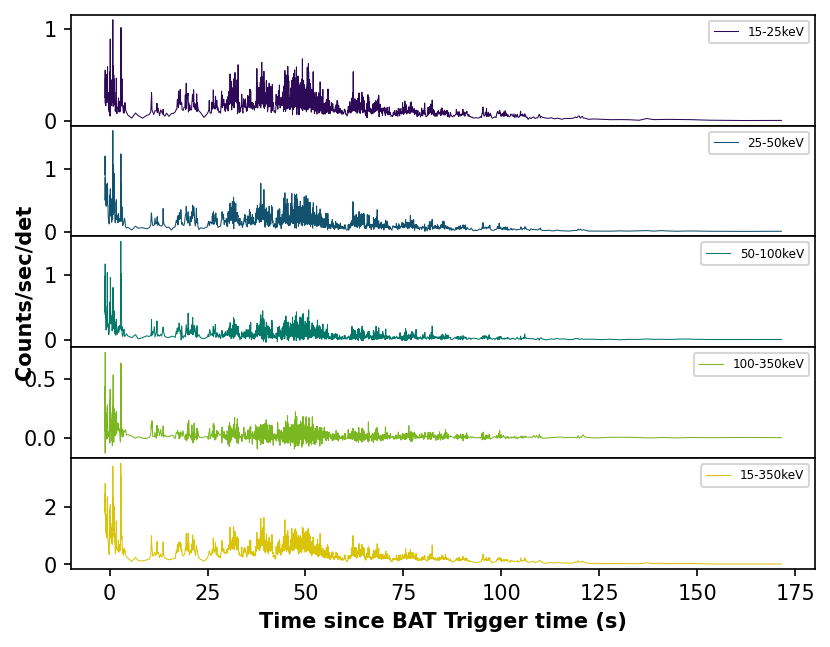

In [4]:
%matplotlib inline
name = 'GRB060614'  # Change this name if you want another GRB
ax = swift.plot_any_grb(name, t=100)

To interpolate this light curve, we need to take each band and fit a polynomial function. The `one_grb_interpolate` instance takes an argument called 'kind' to select the polynomial order, namely:
* 'linear' to use 1-order polynomial
* 'quadratic' to use 2-order polynomial
* 'cubic' to use 3-order polynomial

There are more types of 'kind' arguments; you can check more info at [this link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html).

Let's see what happens when we use interpolate with kind='linear' between $T_{100}$:

In [5]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def interpolate_light_curve(lc_data, new_time=None, points_per_band=4, kind='linear'):
    """
    Interpolate a light curve in a Pandas DataFrame or an array where the time data is in the first column, and the
    band measurements are in the next columns. Supports interpolation of up to 5 bands. If a non-linear interpolation
    is selected, it can use an additional input to indicate how much points per band will be used to interpolate.

    Args:
    - lc_data (pd.DataFrame or array-like): Light curve data to be interpolated. If lc_data is an array-like, the first
    column should contain the time data, and the next columns should contain the band measurements. If lc_data is a
    Pandas DataFrame, the first column should be the index, and the next columns should contain the band measurements.
    - new_time (array-like): If provided, the returned array will be the interpolated points in new_time.
    - points_per_band (int): Number of points per band to use for non-linear interpolations (e.g. quadratic).
    Default is 2.
    - kind (str): Type of interpolation to use. Supported types are 'linear', 'nearest', 'zero', 'slinear',
    'quadratic', 'cubic'. Default is 'linear'.

    Returns:
    - lc_interp (array-like): Interpolated light curve data.
    """

    # Convert input data to Pandas DataFrame
    if not isinstance(lc_data, pd.DataFrame):
        lc_data = pd.DataFrame(lc_data)

    # Get time data from first column
    time_data = lc_data.iloc[:, 0]

    # Get band measurements data from remaining columns
    band_data = lc_data.iloc[:, 1:]

    # Define time data to interpolate on
    if new_time is None:
        new_time = np.linspace(time_data.min(), time_data.max(), len(time_data))

    # Define interpolation function for each band
    interp_funcs = []
    for i in range(band_data.shape[1]):
        band = band_data.iloc[:, i]
        if kind == 'linear':
            interp_funcs.append(interp1d(time_data, band, kind=kind, fill_value='extrapolate'))
        else:
            interp_funcs.append([])
            for j in range(0, len(band), points_per_band):
                interp_funcs[i].append(interp1d(time_data[j:j+points_per_band],
                                                band[j:j+points_per_band],
                                                kind=kind, fill_value='extrapolate'))

    # Interpolate each band
    lc_interp = []
    for i in range(band_data.shape[1]):
        band_interp = []
        if kind == 'linear':
            band_interp = interp_funcs[i](new_time)
        else:
            for j in range(len(interp_funcs[i])):
                band_interp.append(interp_funcs[i][j](new_time))
            band_interp = np.concatenate(band_interp)
        lc_interp.append(band_interp)

    # Combine time data with interpolated band data
    lc_interp = np.column_stack([new_time, *lc_interp])

    return lc_interp

In [6]:
grb = 'GRB060614'
example = swift.obtain_data(name=grb)
times = np.asarray(example[swift.column_labels[0]])
new_times = interpolate_light_curve(example, new_time=np.linspace(times[0], times[-1], 50000))

In [7]:
import matplotlib.pyplot as plt

print(example)

      Time(s)  15-25keV  15-25Err  25-50keV  25-50Err  50-100keV  50-100Err  \
0    -234.760  0.001820  0.003985 -0.006276  0.004064  -0.000609   0.003622   
1    -224.759  0.002389  0.003992  0.003860  0.004129  -0.000929   0.003696   
2    -214.759  0.009361  0.003972  0.005034  0.004095  -0.000683   0.003599   
3    -204.758 -0.002023  0.003961 -0.004737  0.004179  -0.005702   0.003653   
4    -194.757  0.005790  0.003976  0.001708  0.004167  -0.003044   0.003744   
...       ...       ...       ...       ...       ...        ...        ...   
2316  420.868 -0.002442  0.001878 -0.005766  0.002311  -0.000710   0.002317   
2317  430.868 -0.002600  0.001966 -0.006344  0.002476   0.004257   0.002491   
2318  440.868 -0.002914  0.002071 -0.003851  0.002639  -0.003034   0.002679   
2319  450.868 -0.002918  0.002187 -0.005814  0.002821   0.002609   0.002879   
2320  469.094 -0.000452  0.000361  0.000218  0.000469   0.000083   0.000478   

      100-350keV  100-350Err  15-350keV  15-350Err 

In [8]:
print(new_times)

[[-2.34760000e+02  1.82000000e-03  3.98500000e-03 ...  3.28100000e-03
  -5.32600000e-03  7.50201000e-03]
 [-2.34745923e+02  1.82080092e-03  3.98500985e-03 ...  3.28092258e-03
  -5.31018144e-03  7.50208218e-03]
 [-2.34731845e+02  1.82160184e-03  3.98501971e-03 ...  3.28084516e-03
  -5.29436289e-03  7.50215436e-03]
 ...
 [ 4.69065845e+02 -4.55809368e-04  3.63820724e-04 ...  6.41909235e-04
  -1.00858985e-03  9.99919045e-04]
 [ 4.69079923e+02 -4.53904684e-04  3.62410362e-04 ...  6.39454617e-04
  -1.00379492e-03  9.96078023e-04]
 [ 4.69094000e+02 -4.52000000e-04  3.61000000e-04 ...  6.37000000e-04
  -9.99000000e-04  9.92237000e-04]]


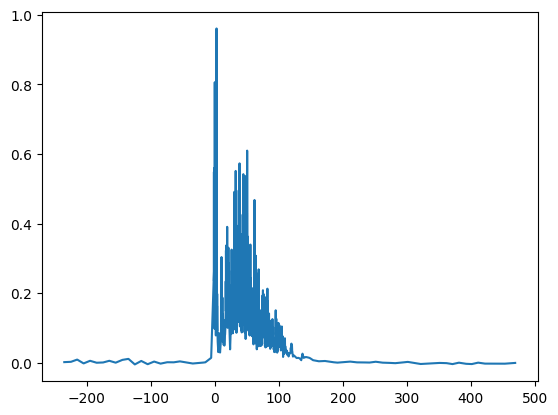

In [9]:
plt.plot(new_times[:, 0], new_times[:, 1])

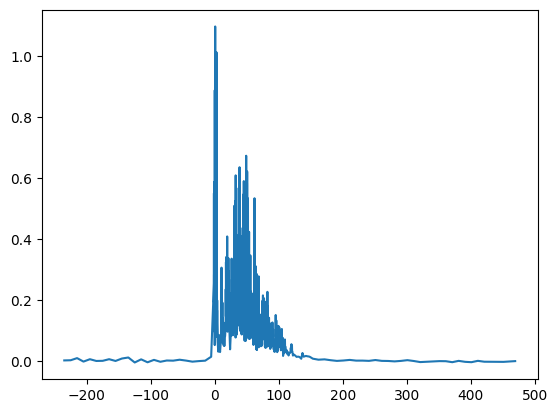

In [10]:
plt.plot(example['Time(s)'], example['15-25keV'])